# Хакатон Моторика


## Часть 1.  Разработка MVP

Для улучшения качества работы наших протезов мы решаем задачу “распознавания жестов”.
В данном хакатоне мы предлагаем решить задачу классификации с известными заранее классами:

Описание данных
X_train.npy и X_test.npy имеют следующие размерности (наблюдения, датчики, время);
y_train.csv содержит следующие классы:

"0" - разгиб жеста "grab";

"1" - разгиб жеста "ok";

"2" - разгиб большого пальца;

"3" - разгиб указательного пальца;

"4" - разгиб жеста "пистолет";

"5" - разгиб среднего пальца;

"6" - разгиб безымянного пальца;

"7" - разгиб мизинца;

"8" - сгиб мизинца;

"9" - сгиб безымянного пальца;

"10" - сгиб среднего пальца;

"11" - сгиб жеста "пистолет";

"12" - сгиб указательного пальца;

"13" - сгиб большого пальца;

"14" - сгиб жеста "ok";

"15" - сгиб жеста "grab";
Задача: построение классификационной модели, которая по показаниям от датчиков будет определять жест, выполненный пользователем протеза во время записи данных, что отражено в значении целевой переменной.

In [126]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [3]:
data = np.load('data/X_train.npy')
data.shape

In [7]:
data = np.reshape(data,(-1,2400))
data.shape

In [83]:
y = pd.read_csv('data/y_train.csv', index_col=0)
y 

,Class
Id,
0,5
1,8
2,11
3,9
4,14
...,...
160,4
161,10
162,3


In [84]:
y = y.Class

Посмотрим на графики сигналов с датчиков.  Напомню, у нас 60 интервалов времени (милисек?), 40 датчиков и 165 наблюдений изначально. 

In [ ]:
gr_data = data.reshape(-1,40,60)
gr_x = np.arange(60)
gesture = 1

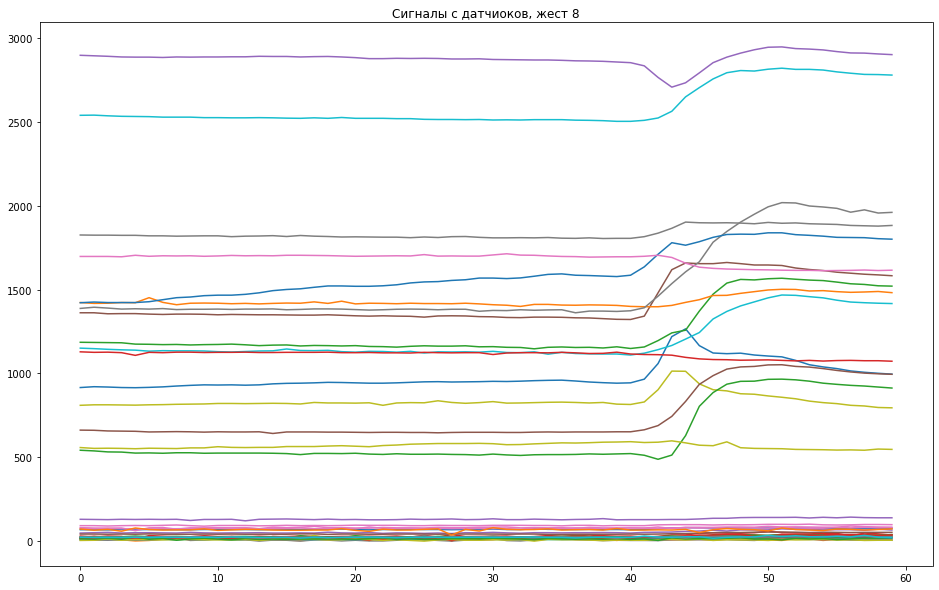

In [130]:
plt.figure(figsize=(16,10))
plt.title('Сигналы с датчиоков, жест '+str(y[gesture]))
for i in range(40): 
    plt.plot(gr_x,gr_data[gesture,i,:])
plt.show();

Соберу статистику по столбцам плоского набора.  Нужен размах для генерации дополнительных наблюдений. 

In [80]:
# рассчет максимального, минимального значений и размаха в столбце
def get_range_vector(data):
    size = data.shape[1]
    mnv = np.zeros(size)
    mxv = np.zeros(size)
    # spv = np.zeros(size)
    for i in range(size): 
        mnv[i]=data[:,i].min()
        mxv[i]=data[:,i].max()
    # spv = mxv - mnv
    return mxv, mnv, mxv - mnv

Собираю статистики по столбцам - максимальное, минимальное значения и размах. 

In [81]:
mxv, mnv, spv = get_range_vector(data)
print(mnv.max(), mnv.min())
print(mxv.max(), mxv.min())
print(spv.max(), spv.min())

2017.0 0.0
3632.0 14.0
2429.0 7.0


 У нас всего 165 отсчетов и этого довольно мало для обучения. Можно просто дополнить данные теми же самыми. Я пробую сгенерировать обучающий набор на лету аналогично тому как это делается в машинном зрении. Функция аугментации аналогично решениям из модуля альбументации для CV.      
 Параметры:
 -  prob - вероятность изменения данных. 
 -  level - доля изменения относительно размаха. 


Функция случайного добавления шума к значениям вектора, размерностью 2400 элементов. 

In [49]:
def add_noise(orig,span,level=0.01,prob=0.5):
    size = orig.shape[0]
    # rv = np.random.rand(size)
    cond = np.where(np.random.rand(size)<=prob,1,0)
    mult = span * (np.random.rand(size)-0.5) * level
    semifin = orig + cond * mult
    return np.where(semifin < 0., 0, semifin)
    

Генерирую набор данных для обучения

In [99]:
was = time.perf_counter()
X_ext = data
y_ext = y
for i in range(2000):
    loc = round(np.random.rand()*164)
    y_ext = pd.concat([y_ext,pd.Series(np.array([y[loc]]), name='Class') ], axis=0, ignore_index=True)
    x_add = add_noise(data[loc,:].reshape(-1),spv).reshape(1,-1)
    X_ext = np.concatenate((X_ext,x_add),axis=0)

print('It takes ',(time.perf_counter()-was),'sec')

It takes  33.77234136599873 sec


In [104]:
print(X_ext.shape)
print(y_ext.shape)

(2165, 2400)
(2165,)


Разделяю данные на обучение и валидацию.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_ext, y_ext, test_size = 0.2)
X_test.shape

(433, 2400)

Пробую логистическую мультиклассовую классификацию. Гиперпараметры предоставил Степан Кутькин. 

In [106]:
LR_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', random_state=42, max_iter=1000)
LR_clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test_review_tfidf)
y_pred = LR_clf.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  1.0


Пробую собрать файл для scoreboard

In [110]:
X_score = np.load('data/X_test.npy')
X_score = np.reshape(X_score,(-1,2400))
X_score.shape

(166, 2400)

In [118]:
y_score = pd.Series(data=LR_clf.predict(X_score),index=np.arange(166)+165,name='Class')
y_score.to_csv('220906_01.csv', index_label='Id')

Kaggle Score 0.98795

Как можно улучшить это направление распознавания жестов? 

1. Можно сделать генерацию новых тайм-фреймов с учетом сдвига по премени вперед или назад на 0.3..0.5 секунды и попробовать обучить модель, посмотреть на результат. 

2. Можно подобрать другие алгоритмя и или гиперпараметры модели. Лучше это делать после решения задачи 1. 